# Downlink Time/Frame Synchronization using PSS in 5G Networks

Downlink time/frame synchronization using Primary Synchronization Signal (PSS) in 5G networks is a vital procedure for ensuring precise timing alignment between the base station (gNB) and user equipment (UE). Here's a more accurate breakdown:

1. **Purpose of Synchronization**: Synchronization is crucial for coordinating transmission and reception in wireless networks. In the downlink direction, precise synchronization ensures that UEs can correctly receive and decode the transmitted signals from the base station.
2. **Primary Synchronization Signal (PSS)**: PSS is a specific signal transmitted periodically by the base station. It consists of unique sequences known as primary synchronization sequences, which convey critical information such as cell identity and timing.
3. **UE Synchronization Process**: When a UE attempts to connect to a 5G network, it scans for nearby cells and detects PSS signals. By decoding the PSS, the UE identifies the cell's identity and estimates the timing offset between its internal clock and the base station's clock.
4. **Frame Synchronization**: Alongside time synchronization, frame synchronization ensures that the UE accurately identifies the boundaries of radio frames transmitted by the base station. This synchronization is essential for proper reception and processing of control and data information within each frame.
5. **Accurate Resource Allocation**: Precise time/frame synchronization enables efficient resource allocation by the base station. Aligned UEs allow optimal utilization of available resources, enhancing system capacity and throughput.
6. **Benefits and Impact**: Accurate downlink synchronization using PSS enhances overall network performance by improving reception quality, facilitating seamless handovers, and enabling efficient resource management. It ensures robust connectivity and enhances the user experience in 5G networks.

In summary, downlink time/frame synchronization using PSS is critical for ensuring reliable and efficient communication in 5G networks, providing precise timing alignment between base stations and user devices for seamless operation and optimal performance.

## Import Libraries

### Import Some Basic Python Libraries

In [1]:

# from IPython.display import display, HTML
# display(HTML("<style>.container { width:90% !important; }</style>"))

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# %matplotlib widget
import matplotlib.pyplot as plt

import numpy as np
import adi


### Import 5G Libraries

In [2]:
from toolkit5G.SequenceGeneration import PSS, SSS, DMRS
from toolkit5G.PhysicalChannels   import PBCH, PBCHDecoder
from toolkit5G.ResourceMapping    import SSB_Grid, ResourceMapperSSB
from toolkit5G.OFDM               import OFDMModulator, OFDMDemodulator
from toolkit5G.MIMOProcessing     import AnalogBeamforming, ReceiveCombining
from toolkit5G.ReceiverAlgorithms import PSSDetection, SSSDetection, ChannelEstimationAndEqualization, DMRSParameterDetection
from toolkit5G.Configurations     import TimeFrequency5GParameters, GenerateValidSSBParameters

## Emulation Parameters

In [3]:
# System Parameters
center_frequency    = 1e9 # Hz

# OFDM Parameters
Bandwidth           = 5*10**6
fftSize             = 1024
subcarrier_spacing  = 15000
numOFDMSymbols      = 14
sample_rate         = fftSize*subcarrier_spacing

# Pulse Shaping
numSamplesPerSymbol = 1


# number of samples returned per call to rx()
buffer_size         = int(fftSize*1.2*numSamplesPerSymbol*numOFDMSymbols) 

## Generate SSB Parameters

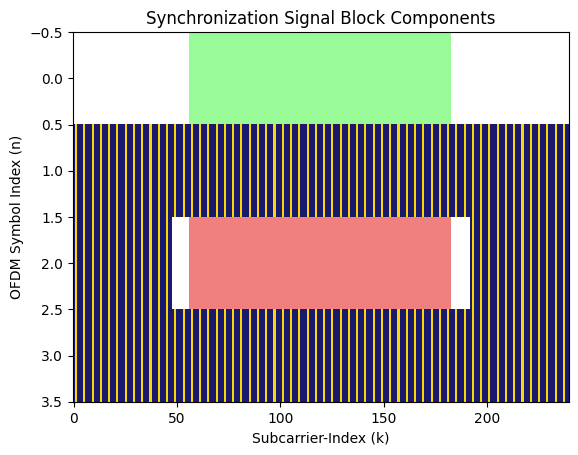

In [4]:
## This class fetches valid set of 5G parameters for the system configurations
nSymbolFrame= int(140*subcarrier_spacing/15000)
## This class fetches valid set of 5G parameters for the system configurations 
tfParams    = TimeFrequency5GParameters(Bandwidth, subcarrier_spacing)
tfParams(nSymbolFrame, typeCP = "normal")
nRB         = tfParams.numRBs        # SSB Grid size (Number of RBs considered for SSB transition)
Neff        = tfParams.Neff        # Number of resource blocks for Resource Grid ( exclude gaurd band | offsets : BWP)
Nfft        = 512                 # FFT-size for OFDM
lengthCP    = tfParams.lengthCP    # CP length
#___________________________________________________________________

#### Generate MIB Information
lamda                           = 3e8/center_frequency;
nSCSOffset                      = 1
ssbParameters                   = GenerateValidSSBParameters(center_frequency, nSCSOffset, "caseA")

systemFrameNumber               = ssbParameters.systemFrameNumber
subCarrierSpacingCommon         = subcarrier_spacing
ssbSubCarrierOffset             = ssbParameters.ssbSubCarrierOffset
DMRSTypeAPosition               = ssbParameters.DMRSTypeAPosition
controlResourceSet0             = ssbParameters.controlResourceSet0
searchSpace0                    = ssbParameters.searchSpace0

isPairedBand                    = ssbParameters.isPairedBand
nSCSOffset                      = ssbParameters.nSCSOffset
choiceBit                       = ssbParameters.choiceBit
ssbType                         = ssbParameters.ssbType
nssbCandidatesInHrf             = ssbParameters.nssbCandidatesInHrf
ssbIndex                        = ssbParameters.ssbIndex
hrfBit                          = ssbParameters.hrfBit
cellBarred                      = ssbParameters.cellBarred
intraFrequencyReselection       = ssbParameters.intraFrequencyReselection
withSharedSpectrumChannelAccess = ssbParameters.withSharedSpectrumChannelAccess

Nsc_ssb                         = 240
Nsymb_ssb                       = 4
#_______________________________________


N_ID2        = np.random.randint(3)

# Generate PSS sequence
pssObject    = PSS(N_ID2);
pssSequence  = pssObject()

N_ID1        = np.random.randint(336)
N_ID         = 3*N_ID1 + N_ID2

# Generate SSS sequence
sssObject    = SSS(N_ID1, N_ID2);
sssSequence  = sssObject()

# Generate DMRS sequence
dmrsLen      = 144;
dmrsObject   = DMRS("PBCH", N_ID, ssbIndex, nssbCandidatesInHrf, hrfBit)
# dmrsSeq = dmrs.getSequence("tensorflow")
dmrsSequence = dmrsObject(dmrsLen)


# Generate PBCH symbols
pbchObject   = PBCH(center_frequency, choiceBit, subCarrierSpacingCommon, DMRSTypeAPosition,
                   controlResourceSet0, searchSpace0, cellBarred, intraFrequencyReselection,
                   systemFrameNumber, ssbSubCarrierOffset, hrfBit, ssbIndex, N_ID,
                   nssbCandidatesInHrf)

pbchSymbols  = pbchObject()

## Generate SSB Object
ssbObject    = SSB_Grid(N_ID, True)
ssb          = ssbObject(pssSequence, sssSequence, dmrsSequence, pbchSymbols)

## Loading SSB to Resource Grid
#####################################
# ssbPositionInBurst = np.ones(nssbCandidatesInHrf, dtype=int)
ssbPositionInBurst    = np.zeros(nssbCandidatesInHrf, dtype=int)
ssbPositionInBurst[0] = 1

ssbRGobject    = ResourceMapperSSB(ssbType=ssbType, carrierFrequency = center_frequency, 
                                   isPairedBand = isPairedBand, 
                                   withSharedSpectrumChannelAccess = withSharedSpectrumChannelAccess)

ssbGrid = ssbRGobject(ssb[0], ssbPositionInBurst, offsetInSubcarriers = ssbSubCarrierOffset[0],
                      offsetInRBs = 0, numRBs = nRB)[0:14]
fig, ax = ssbObject.displayGrid(option=1)

## Construct Transmission Grid and Generate Time Domain Samples

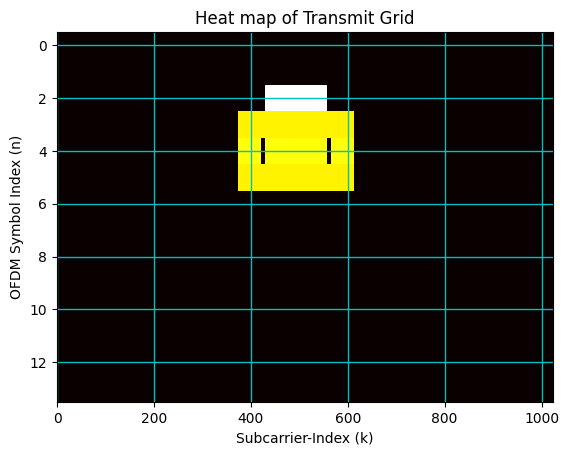

In [5]:
## Loading SSB to Resource Grid
numofGuardCarriers = (int((fftSize - Neff)/2), int((fftSize - Neff)/2))
offsetToPointA     = 0
firstSCIndex       = int(numofGuardCarriers[0] + offsetToPointA)
numOFDMSymbols     = ssbGrid.shape[0]

X = np.zeros((numOFDMSymbols, fftSize), dtype= np.complex64)
X[:, firstSCIndex:firstSCIndex+ssbGrid.shape[-1]] = ssbGrid

#__________________________________________________

## OFDM Modulation at Transmitter
#####################################
modulator = OFDMModulator(lengthCP[1])
x_time    = modulator(X).flatten()
#______________________________________________________

# Plot Resource Grid
#################################################################
fig, ax = plt.subplots()
plt.imshow(np.abs(X), cmap = 'hot', interpolation='nearest', aspect = "auto")
ax = plt.gca();
ax.grid(color='c', linestyle='-', linewidth=1)
ax.set_xlabel("Subcarrier-Index (k)")
ax.set_ylabel("OFDM Symbol Index (n)")
ax.set_title("Heat map of Transmit Grid")
# Gridlines based on minor ticks
plt.show()

## SDR-Setup Configurations

In [6]:
# Basic SDR Setup
sdr = adi.Pluto("ip:192.168.2.1")
sdr.sample_rate = int(sample_rate)

# Config Tx
sdr.tx_rf_bandwidth = int(sample_rate) # filter cutoff, just set it to the same as sample rate
sdr.tx_lo           = int(center_frequency)
sdr.tx_hardwaregain_chan0 = -0 # Increase to increase tx power, valid range is -90 to 0 dB

# Config Rx
sdr.gain_control_mode_chan0 = 'manual'
sdr.rx_hardwaregain_chan0   = 40.0      # dB
# The receive gain on the Pluto has a range from 0 to 74.5 dB.

# sdr.gain_control_mode_chan0 = 'slow_attack'
# # AGC modes: 
#     # 1. "manual"
#     # 2. "slow_attack"
#     # 3. "fast_attack"

sdr.rx_lo           = int(center_frequency)
sdr.rx_rf_bandwidth = int(60*10**6) # filter width, just set it to the same as sample rate for now
sdr.rx_buffer_size  = int(buffer_size)

## Transmission: SDR RF Transmitter

In [7]:

# Start the transmitter
sdr.tx_cyclic_buffer = True # Enable cyclic buffers
# sdr.tx_cyclic_buffer = False # Enable cyclic buffers
sdr.tx(1.3*2**17*(x_time.repeat(1))) # start transmitting


## Reception: SDR RF Receiver

In [8]:

# Clear buffer just to be safe
for i in range (0, 10):
    raw_data = sdr.rx()

# Receive samples
rx_samples = sdr.rx()

# # Stop transmitting
# sdr.tx_destroy_buffer()


## Time Synchronization: Based on PSS Correlation

**(rasterOffset, PSS-ID) (374, 0)
**(rasterOffset, PSS-ID) (374, 1)
**(rasterOffset, PSS-ID) (374, 2)


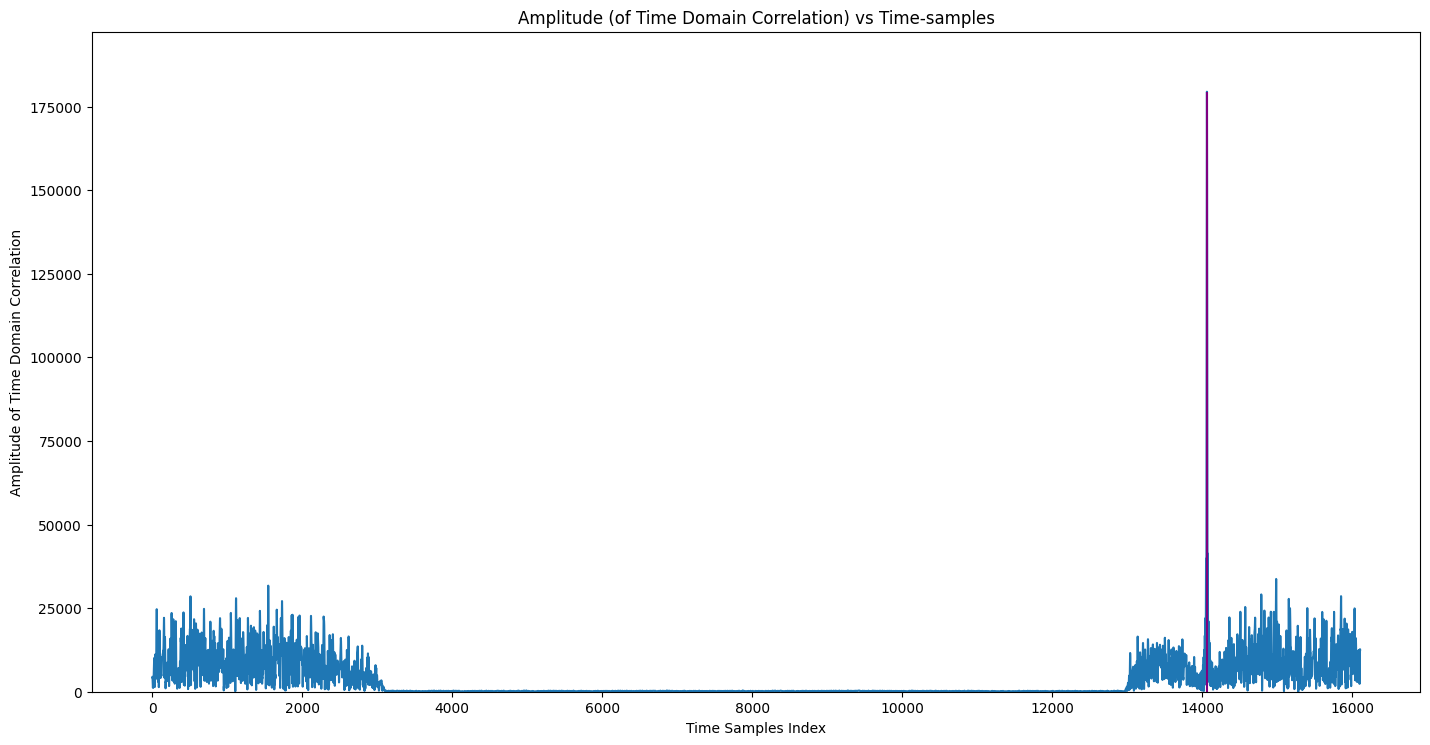

In [9]:
## PSS Detection: Based on time domain PSS Correlation
# pssPeakIndices, pssCorrelation, rN_ID2 = pssDetection(r, Nfft, lengthCP = lengthCP[1],
#                                                       N_ID2 = None, freqOffset = ssboffset,
#                                                       height = 0.75, prominence = 0.65, width=10)
## PSS Detection: Based on time domain PSS Correlation
# pssDetection   = PSSDetection("correlation", "threshold")

pssDetection   = PSSDetection("largestPeak")
ssboffset      = int((fftSize-Neff)/2+ssbRGobject.startingSubcarrierIndices)
pssPeakIndices, pssCorrelation, rN_ID2, freqOffset = pssDetection(rx_samples, fftSize, lengthCP = lengthCP[1], 
                                                                  nID2=None, freqOffset = ssboffset)

## PSS Detection Plot
#################################################################
scaleFig = 1.75
fig, ax  = plt.subplots(figsize=(30/scaleFig, 15/scaleFig))

# single line
ax.plot(pssCorrelation)
ax.vlines(x = pssPeakIndices, ymin = 0*pssCorrelation[pssPeakIndices],
           ymax = pssCorrelation[pssPeakIndices], colors = 'purple')
ax.set_ylim([0,np.max(pssCorrelation)*1.1])
ax.set_xlabel("Time Samples Index")
ax.set_ylabel("Amplitude of Time Domain Correlation")
ax.set_title("Amplitude (of Time Domain Correlation) vs Time-samples")
plt.show()
#________________________________________________________________

## Frame Synchronization: Visualization

``Note``: The following snippet of code only works with interactive maplotlib.

In [ ]:
import matplotlib.patches as patches
import matplotlib.animation as animation

In [10]:
correlation    = np.zeros((3, pssCorrelation.size), dtype = np.float32)
r              = rx_samples[i:i+fftSize]
correlation[0] = np.abs(np.correlate(rx_samples, np.squeeze(pssDetection.pssRTime[0]), mode='valid'))
correlation[1] = np.abs(np.correlate(rx_samples, np.squeeze(pssDetection.pssRTime[1]), mode='valid'))
correlation[2] = np.abs(np.correlate(rx_samples, np.squeeze(pssDetection.pssRTime[2]), mode='valid'))

# function that draws each frame of the animation
def animate(i):

    ax[0].clear()
    ax[0].grid()
    ax[0].plot(correlation[0,0:scale*(i+1)], color='k', label = "Correlation With PSS with $n_{ID}^{2}=0$")
    ax[0].legend()
    ax[0].set_xlim([0,pssCorrelation.size])
    ax[0].set_ylim([0,np.max(pssCorrelation)*1.1])

    ax[1].clear()
    ax[1].grid()
    ax[1].plot(correlation[1,0:scale*(i+1)], color='g', label = "Correlation With PSS with $n_{ID}^{2}=1$")
    ax[1].legend()
    ax[1].set_xlim([0,pssCorrelation.size])
    ax[1].set_ylim([0,np.max(pssCorrelation)*1.1])

    ax[2].clear()
    ax[2].grid()
    ax[2].plot(correlation[2,0:scale*(i+1)], color='b', label = "Correlation With PSS with $n_{ID}^{2}=2$")
    ax[2].legend()
    ax[2].set_xlim([0,pssCorrelation.size])
    ax[2].set_ylim([0,np.max(pssCorrelation)*1.1])
    
    ax[3].clear()
    ax[3].grid()
    ax[3].plot(np.real(rx_samples[0:scale*(i+1)]), color='r', label = "real part of received signal")
    ax[3].plot(np.imag(rx_samples[0:scale*(i+1)]), color='y', label = "imaginary part of received signal")
    ax[3].legend()
    ax[3].set_xlim([0,pssCorrelation.size])
    ax[3].set_ylim([minX,maxY])

#     ax[0].set_xlabel('Freq (sec)')
#     ax[0].set_ylabel('Received-Power (dB)')
#     ax[0].set_title('Power Spectrum', fontsize=12)
# #     ax[0].set_ylim([0,85])
#     ax[0].legend()

#     ax[1].clear()
#     ax[1].grid()
#     ax[1].plot(np.real(rx_samples[0:400]), label = "Real part")
#     ax[1].plot(np.imag(rx_samples[0:400]), label = "Imaginary part")
#     ax[1].set_xlabel("Time")
#     ax[1].set_ylabel('Received signal')
#     ax[1].set_title('Received signal vs Time', fontsize=12)
#     ax[1].legend()

# fig.clear()
minX = np.min([np.real(rx_samples).min(), np.imag(rx_samples).min()])
maxY = np.max([np.real(rx_samples).max(), np.imag(rx_samples).max()])
# create the figure and axes objects
scaleFig = 1.75
fig, ax  = plt.subplots(4,1,figsize=(30/scaleFig, 20/scaleFig))
fig.suptitle('Spectrum of the Received Signal', fontsize=10)

scale = 100
#####################
# run the animation
#####################
# frames= 20 means 20 times the animation function is called.
# interval=500 means 500 milliseconds between each frame.
# repeat=False means that after all the frames are drawn, the animation will not repeat.
# Note: plt.show() line is always called after the FuncAnimation line.


anim = animation.FuncAnimation(fig, animate, frames=int(np.floor((correlation.size-1)/scale)), interval=1, repeat=False, blit=True)
# saving to mp4 using ffmpeg writer
# writervideo = animation.FFMpegWriter(fps=30)
# anim.save('SimulationOfNodeMobility.mp4', writer=writervideo)
# anim.save('SimulationOfNodeMobility.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
# anim.save("mobility.gif", fps = 2)
plt.show()

anim.save("Overall.gif", fps = 10)

writervideo = animation.FFMpegWriter(fps=60) 
anim.save('Overall.mp4', writer=writervideo)

![](Overall.gif)

## Saving Running frames

In [11]:

# function that draws each frame of the animation
def animate(i):
    if scale*i+fftSize < rx_samples.size:
        ax1[3].clear()
        ax1[3].grid()
        ax1[3].plot(np.arange(scale*i,(scale*i+fftSize)), np.real(rx_samples[scale*i:(scale*i+fftSize)]), color='r', label = "real part of received signal")
        ax1[3].plot(np.arange(scale*i,(scale*i+fftSize)), np.imag(rx_samples[scale*i:(scale*i+fftSize)]), color='y', label = "imaginary part of received signal")
        ax1[3].legend()
        ax1[3].set_xlim([scale*i, scale*i+fftSize])
        ax1[3].set_ylim([minX,maxY])

#     ax1[0].set_xlabel('Freq (sec)')
#     ax1[0].set_ylabel('Received-Power (dB)')
#     ax1[0].set_title('Power Spectrum', fontsize=12)
# #     ax1[0].set_ylim([0,85])
#     ax1[0].legend()

#     ax1[1].clear()
#     ax1[1].grid()
#     ax1[1].plot(np.real(rx_samples[0:400]), label = "Real part")
#     ax1[1].plot(np.imag(rx_samples[0:400]), label = "Imaginary part")
#     ax1[1].set_xlabel("Time")
#     ax1[1].set_ylabel('Received signal')
#     ax1[1].set_title('Received signal vs Time', fontsize=12)
#     ax1[1].legend()


# create the fig1ure and axes objects
scalefig1 = 1.75
fig1, ax1  = plt.subplots(4,1,figsize=(30/scalefig1, 20/scalefig1))
fig1.suptitle('Spectrum of the Received Signal', fontsize=10)

minX = np.min([np.real(pssDetection.pssRTime[0]).min(), np.imag(pssDetection.pssRTime[0]).min()])
maxY = np.max([np.real(pssDetection.pssRTime[0]).max(), np.imag(pssDetection.pssRTime[0]).max()])

ax1[0].plot(np.real(pssDetection.pssRTime[0]), color='k', label = "real part of Time domain PSS with $n_{ID}^{2}=0$")
ax1[0].plot(np.imag(pssDetection.pssRTime[0]), color='r', label = "imaginary part of Time domain PSS with $n_{ID}^{2}=0$")
ax1[0].legend()
ax1[0].set_xlim([0,pssDetection.pssRTime[2].size])
ax1[0].set_ylim([minX,maxY])

minX = np.min([np.real(pssDetection.pssRTime[1]).min(), np.imag(pssDetection.pssRTime[1]).min()])
maxY = np.max([np.real(pssDetection.pssRTime[1]).max(), np.imag(pssDetection.pssRTime[1]).max()])

ax1[1].plot(np.real(pssDetection.pssRTime[1]), color='k', label = "real part of Time domain PSS with $n_{ID}^{2}=1$")
ax1[1].plot(np.imag(pssDetection.pssRTime[1]), color='r', label = "imaginary part of Time domain PSS with $n_{ID}^{2}=1$")
ax1[1].legend()
ax1[1].set_xlim([0,pssDetection.pssRTime[2].size])
ax1[1].set_ylim([minX,maxY])

minX = np.min([np.real(pssDetection.pssRTime[2]).min(), np.imag(pssDetection.pssRTime[2]).min()])
max1Y = np.max([np.real(pssDetection.pssRTime[2]).max(), np.imag(pssDetection.pssRTime[2]).max()])
ax1[2].plot(np.real(pssDetection.pssRTime[2]), color='k', label = "real part of Time domain PSS with $n_{ID}^{2}=2$")
ax1[2].plot(np.imag(pssDetection.pssRTime[2]), color='r', label = "imaginary part of Time domain PSS with $n_{ID}^{2}=2$")
ax1[2].legend()
ax1[2].set_xlim([0,pssDetection.pssRTime[2].size])
ax1[2].set_ylim([minX,maxY])

# fig1.clear()
minX = np.min([np.real(rx_samples).min(), np.imag(rx_samples).min()])
maxY = np.max([np.real(rx_samples).max(), np.imag(rx_samples).max()])

scale = 100
#####################
# run the animation
#####################
# frames= 20 means 20 times the animation function is called.
# interval=500 means 500 milliseconds between each frame.
# repeat=False means that after all the frames are drawn, the animation will not repeat.
# Note: plt.show() line is always called after the FuncAnimation line.


anim1 = animation.FuncAnimation(fig1, animate, frames=int(np.floor((rx_samples.size-1)/scale)-1), interval=1, repeat=False, blit=True)
# saving to mp4 using ffmpeg writer
# writervideo = animation.FFMpegWriter(fps=30)
# anim.save('SimulationOfNodeMobility.mp4', writer=writervideo)
# anim.save('SimulationOfNodeMobility.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
# anim.save("mobility.gif", fps = 2)
plt.show()

anim1.save("Overall_frame.gif", fps = 10)

writervideo = animation.FFMpegWriter(fps=60) 
anim1.save('Overall_frame.mp4', writer=writervideo)

![](Overall_frame.gif)